In [1]:
import os
from glob import glob
from pathlib import Path
import pandas as pd

import numpy as np
import collections
import matplotlib.pyplot as plt
import scipy.sparse as sp

import networkx as nx
import igraph as ig

from utils import project_utils as p_utils

In [2]:
def load_data(file_name):
    with np.load(file_name, allow_pickle=True) as loader:
        S = sp.csr_matrix((loader['adj_data'], loader['adj_indices'],
                                              loader['adj_indptr']), shape=loader['adj_shape'])
        if 'attr_data' in loader:
            X = sp.csr_matrix((loader['attr_data'], loader['attr_indices'],
                                                   loader['attr_indptr']), shape=loader['attr_shape'])
        else:
            X = None

        Label = loader.get('labels')

    return S,X,Label

In [3]:
def parse_features(feature_path):
    features_file = open(feature_path, 'r')
    features = features_file.readlines()
    features_parsed = []

    for line in features:
        itm_features = []
        for itm in line.split(','):
            try:
               itm_features.append(float(itm))
            except: pass
        
        features_parsed.append(itm_features)

    features_file.close()
    return features_parsed

In [4]:
def adj_list_to_matrix(adj_list):
    n = len(adj_list)
    adj_matrix = np.nan * np.ones((n,n))
    np.fill_diagonal(adj_matrix,0)

    for i in range(n):
        for j in adj_list[i]:
            adj_matrix[i][j] = 1
    return adj_matrix

In [5]:
result_directory = 'results/'
original_data_directory = 'data/raw/'

In [6]:
methods = [
           'real-world', 
           'acMark', 
           'cabam', 
           'mag'
           ]
datasets = [
            'citeseer', 
            'cora', 
            'cora_ml', 
            'polblogs', 
            'pubmed'
            ]

GRAPHS = {}

for method in methods: GRAPHS[method] = {}

In [7]:
# Loading original networks and features
for n in datasets:
    file_path = original_data_directory + n + '.npz'
    S,X,_ = load_data(file_path)

    print(f'Loading graph and features for {n} dataset')

    GRAPHS['real-world'][n] = {
        'nx': nx.convert_matrix.from_scipy_sparse_matrix(S),
        'ig': ig.Graph.Adjacency(S.toarray().tolist()),
        'features': X.toarray()
    }

    print('Loaded successfuly\n')


Loading graph and features for citeseer dataset
Loaded successfuly

Loading graph and features for cora dataset
Loaded successfuly

Loading graph and features for cora_ml dataset
Loaded successfuly

Loading graph and features for polblogs dataset
Loaded successfuly

Loading graph and features for pubmed dataset
Loaded successfuly



In [8]:
# Loading generated networks and features
for method in methods:
  if method == 'real-world': continue
  for dataset in datasets:
    results_path = result_directory + method + '/' + dataset + '/'
    if not Path(results_path + 'G.csv').is_file(): continue 
    print(f'Loading graph and features generated by {method} from {dataset} dataset')

    df = pd.read_csv(results_path + 'G.csv', comment='#', header=None)
    GRAPHS[method][dataset] = {
        'nx': nx.readwrite.adjlist.read_adjlist(results_path + 'G.csv'),
        'ig': ig.Graph.Adjacency(adj_list_to_matrix(
            [list( map(int,i) ) for i in [lst[0].split(' ')[1:] for lst in df.values]]
        )),
        'features': parse_features(results_path + 'Features.csv')
    }

    print('Loaded successfuly\n')

Loading graph and features generated by acMark from citeseer dataset
Loaded successfuly

Loading graph and features generated by acMark from cora dataset
Loaded successfuly

Loading graph and features generated by acMark from cora_ml dataset
Loaded successfuly

Loading graph and features generated by acMark from polblogs dataset
Loaded successfuly

Loading graph and features generated by acMark from pubmed dataset
Loaded successfuly

Loading graph and features generated by cabam from citeseer dataset
Loaded successfuly

Loading graph and features generated by cabam from cora dataset
Loaded successfuly

Loading graph and features generated by cabam from cora_ml dataset
Loaded successfuly

Loading graph and features generated by cabam from polblogs dataset
Loaded successfuly

Loading graph and features generated by cabam from pubmed dataset
Loaded successfuly

Loading graph and features generated by mag from polblogs dataset
Loaded successfuly



In [13]:
import ray
ray.init()

2021-05-30 19:00:51,661	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.0.76',
 'raylet_ip_address': '192.168.0.76',
 'redis_address': '192.168.0.76:6379',
 'object_store_address': '/tmp/ray/session_2021-05-30_19-00-49_389754_30725/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-05-30_19-00-49_389754_30725/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-05-30_19-00-49_389754_30725',
 'metrics_export_port': 60249,
 'node_id': '5d51e24749adac804cf47173850cee4efb0a0bb7f14e6c99be114813'}

In [15]:
# a function to compute structural features of a graph in paralel
@ray.remote
def count(method, dataset, exists, G_ig=None, G_nx=None):
    
    if not exists: return f'{dataset},{method},-1,-1,-1,-1,-1'

    v = G_ig.vcount()
    e = G_ig.ecount()
    p = G_ig.average_path_length()

    largest_cc = max(nx.connected_components(G_nx), key=len)
    G_cc = G_nx.subgraph(largest_cc).copy()

    d = nx.algorithms.distance_measures.diameter(G_cc)
    r = nx.algorithms.distance_measures.radius(G_cc)

    return f'{dataset},{method},{v},{e},{d},{r},{p}'

In [16]:
# Graph analisys

tasks = []

for method in methods:
    for dataset in datasets:
        if method in GRAPHS.keys():
            if dataset in GRAPHS[method].keys():
                G_nx, G_ig, features = GRAPHS[method][dataset].values()
                tasks.append(count.remote(method, dataset, True, G_ig, G_nx))
            else:
                tasks.append(count.remote(method, dataset, False))

results = ray.get(tasks)

(pid=31118) acMark-polblogs  done
(pid=31118) acMark-polblogs  done
(pid=31114) acMark-citeseer  done
(pid=31114) acMark-citeseer  done
(pid=31120) real-world-citeseer  done
(pid=31120) real-world-citeseer  done
(pid=31111) acMark-cora_ml  done
(pid=31111) acMark-cora_ml  done
(pid=31109) cabam-citeseer  done
(pid=31109) cabam-citeseer  done
(pid=31112) cabam-cora  done
(pid=31112) cabam-cora  done
(pid=31114) cabam-polblogs  done
(pid=31114) cabam-polblogs  done
(pid=31118) cabam-cora_ml  done
(pid=31118) cabam-cora_ml  done
(pid=31120) cabam-pubmed  done
(pid=31120) cabam-pubmed  done
(pid=31117) real-world-polblogs  done
(pid=31117) real-world-polblogs  done
(pid=31115) real-world-cora_ml  done
(pid=31115) real-world-cora_ml  done
(pid=31111) mag-polblogs  done
(pid=31111) mag-polblogs  done
(pid=31110) acMark-pubmed  done
(pid=31110) acMark-pubmed  done
(pid=31113) acMark-cora  done
(pid=31113) acMark-cora  done
(pid=31119) real-world-cora  done
(pid=31119) real-world-cora  done
(p

In [17]:
ray.shutdown()

In [19]:
print('Name,Method,Vertecies Count, Edge Count, Diameter, Radius, Average Path Length')
for r in results:
    print(r)

Name,Method,Vertecies Count, Edge Count, Diameter, Radius, Average Path Length
citeseer,real-world,4230,5358,23,12,1.8017187360128906
cora,real-world,19793,65311,23,12,16.552132443455456
cora_ml,real-world,2995,8416,17,9,9.387856944146966
polblogs,real-world,1490,19090,8,4,3.3901837252152363
pubmed,real-world,19717,88648,18,10,6.336870027999047
citeseer,acMark,1681,2871,15,8,2.9101019462465247
cora,acMark,18800,61559,13,7,5.414560048017285
cora_ml,acMark,2810,7684,11,6,4.014463127478405
polblogs,acMark,1222,15481,6,4,2.513776982690547
pubmed,acMark,19717,43853,15,8,4.951885565669701
citeseer,cabam,3000,29900,5,3,4.088822663423849
cora,cabam,3000,29900,4,3,3.847229292968219
cora_ml,cabam,3000,29900,4,3,3.9737416797690157
polblogs,cabam,3000,29900,5,3,3.8841446435676583
pubmed,cabam,3000,29900,4,3,3.8415240198785203
citeseer,mag,-1,-1,-1,-1,-1
cora,mag,-1,-1,-1,-1,-1
cora_ml,mag,-1,-1,-1,-1,-1
polblogs,mag,3000,677967,2,2,2.0305173342913596
pubmed,mag,-1,-1,-1,-1,-1


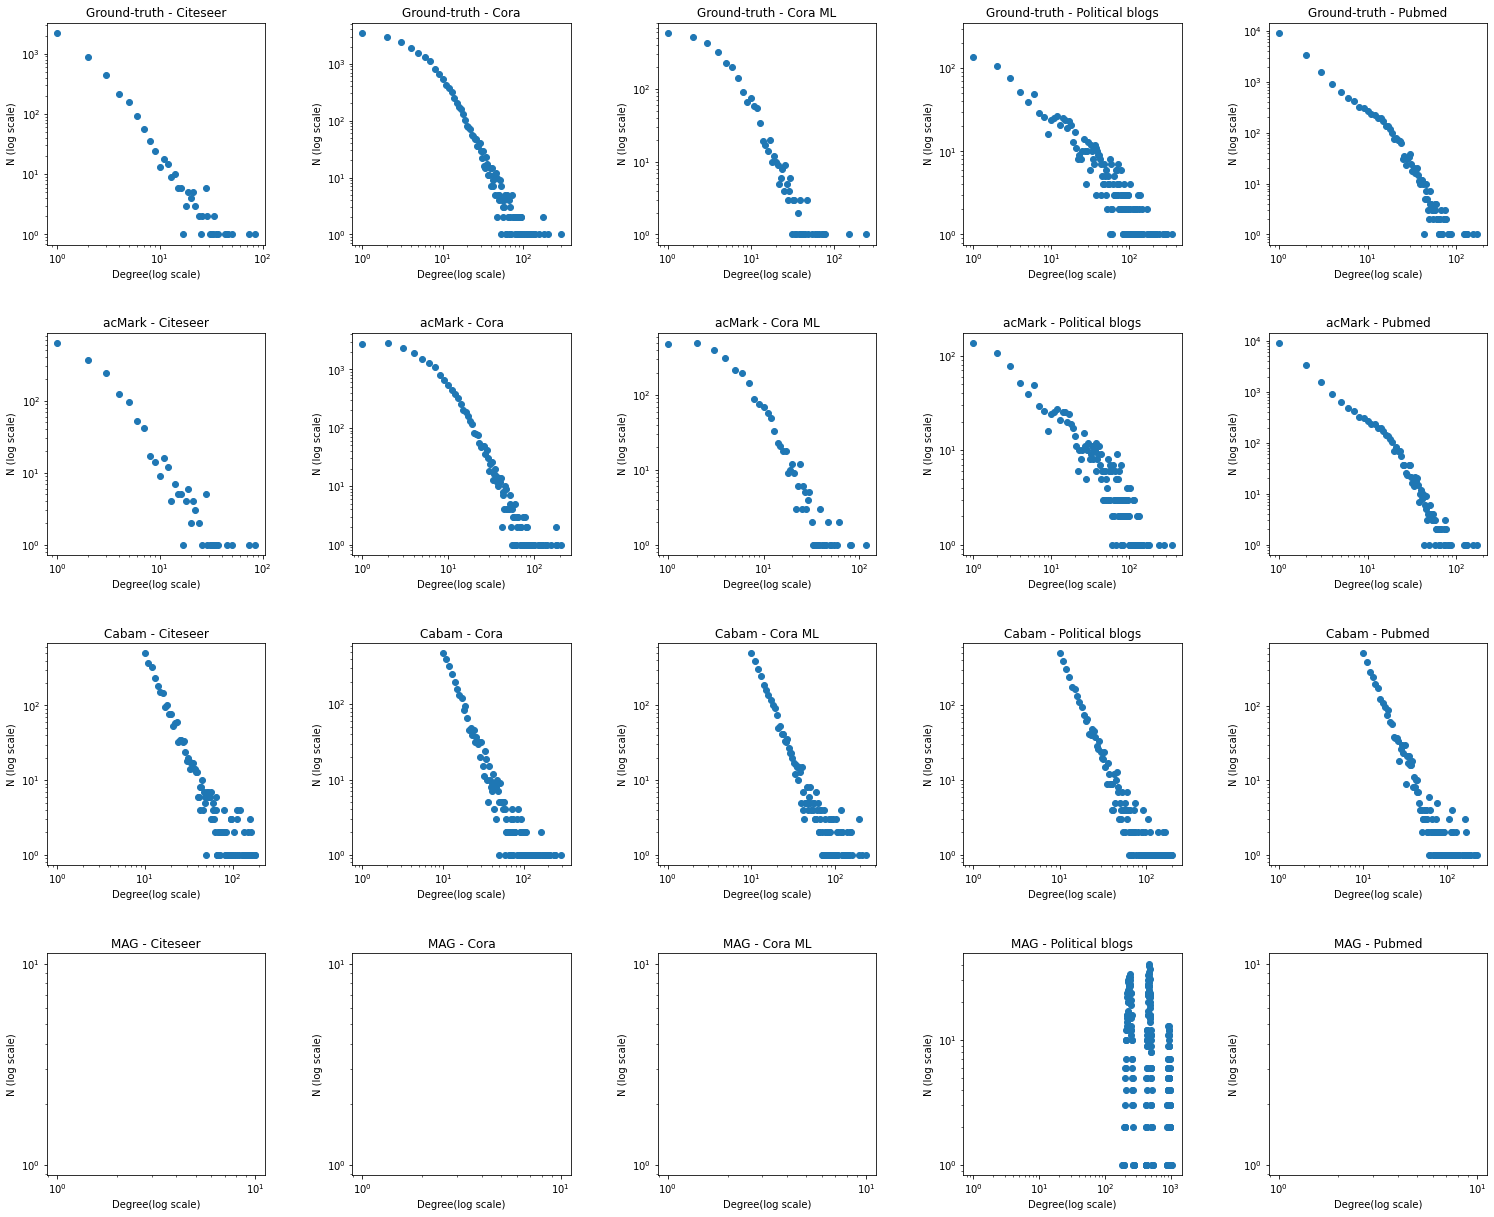

In [21]:
freendly_keeys = {
    'real-world': 'Ground-truth',
    'acMark': 'acMark',
    'cabam': 'Cabam',
    'mag': 'MAG',
    'citeseer': 'Citeseer',
    'cora': 'Cora',
    'cora_ml': 'Cora ML',
    'polblogs': 'Political blogs',
    'pubmed': 'Pubmed'
}

# Degree distribution analisys
fig, axs = plt.subplots(len(methods), len(datasets), figsize=(25,20))

for i, method in enumerate(methods):
    for j, dataset in enumerate(datasets):
        if method in GRAPHS.keys():
            
            axs[i, j].set_title(f'{freendly_keeys[method]} - {freendly_keeys[dataset]}')
            axs[i, j].set_xlabel('Degree(log scale)')
            axs[i, j].set_ylabel('N (log scale)')
            axs[i, j].set_xscale('log')
            axs[i, j].set_yscale('log')

        if dataset in GRAPHS[method].keys():
            G = GRAPHS[method][dataset]['nx']

            aux_y = nx.degree_histogram(G)
            aux_x = np.arange(0,len(aux_y)).tolist()
            n_nodes = G.number_of_nodes()
            axs[i, j].plot(aux_x, aux_y, 'o')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
